For reasons unknown to me, I am unable to import and implement the Chronos model. Consequently, unfortunately, I am unable to complete my homework without this model. I planned to do others, but there are also issues with those. TensorFlow crashes the kernel, and NLTK also crashes the kernel during import.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)
start_date = '2022-01-01'
end_date = '2023-08-31'
dates = pd.date_range(start=start_date, end=end_date, freq='H')
n_points = len(dates)
trend = np.linspace(5000, 6000, n_points) + np.random.normal(0, 50, n_points)
daily_seasonality = 1000 * np.sin(2 * np.pi * dates.hour / 24)
weekly_seasonality = 500 * np.sin(2 * np.pi * dates.dayofweek / 7)
consumption = trend + daily_seasonality + weekly_seasonality + np.random.normal(0, 150, n_points)
df = pd.DataFrame({'DateTime': dates, 'Consumption': consumption})
df.set_index('DateTime', inplace=True)

/var/folders/xr/v5m61tlj65x51xn5n3hz1ll40000gn/T/ipykernel_31527/1538928434.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=start_date, end=end_date, freq='H')


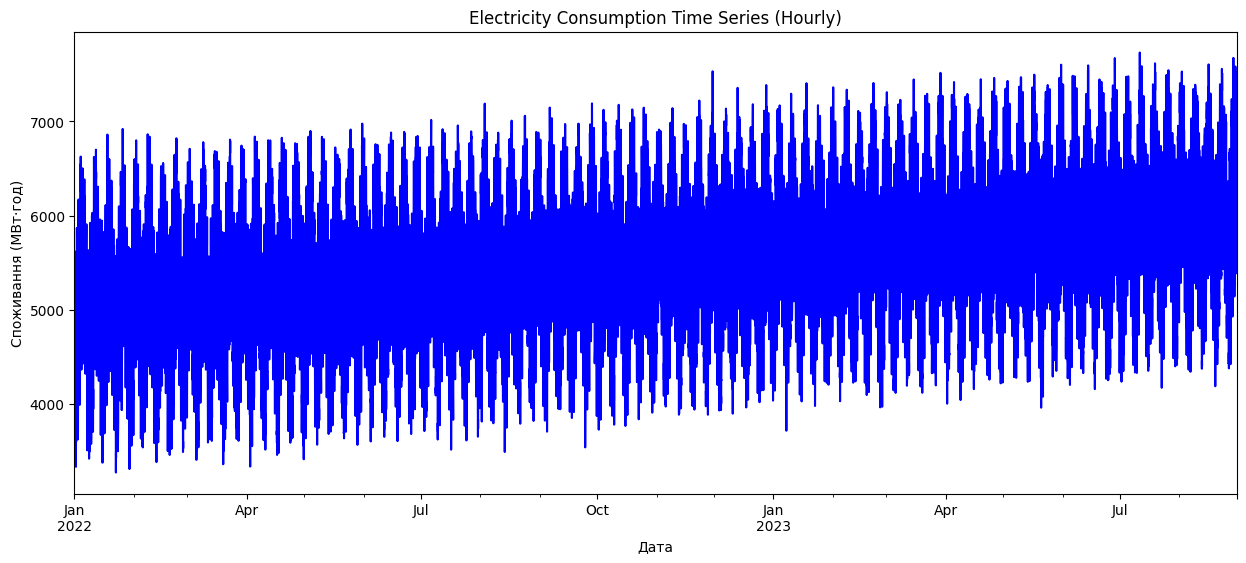

In [3]:
plt.figure(figsize=(15, 6))
df['Consumption'].plot(title='Electricity Consumption Time Series (Hourly)', color='blue')
plt.xlabel('Дата')
plt.ylabel('Споживання (МВт·год)')
plt.show()

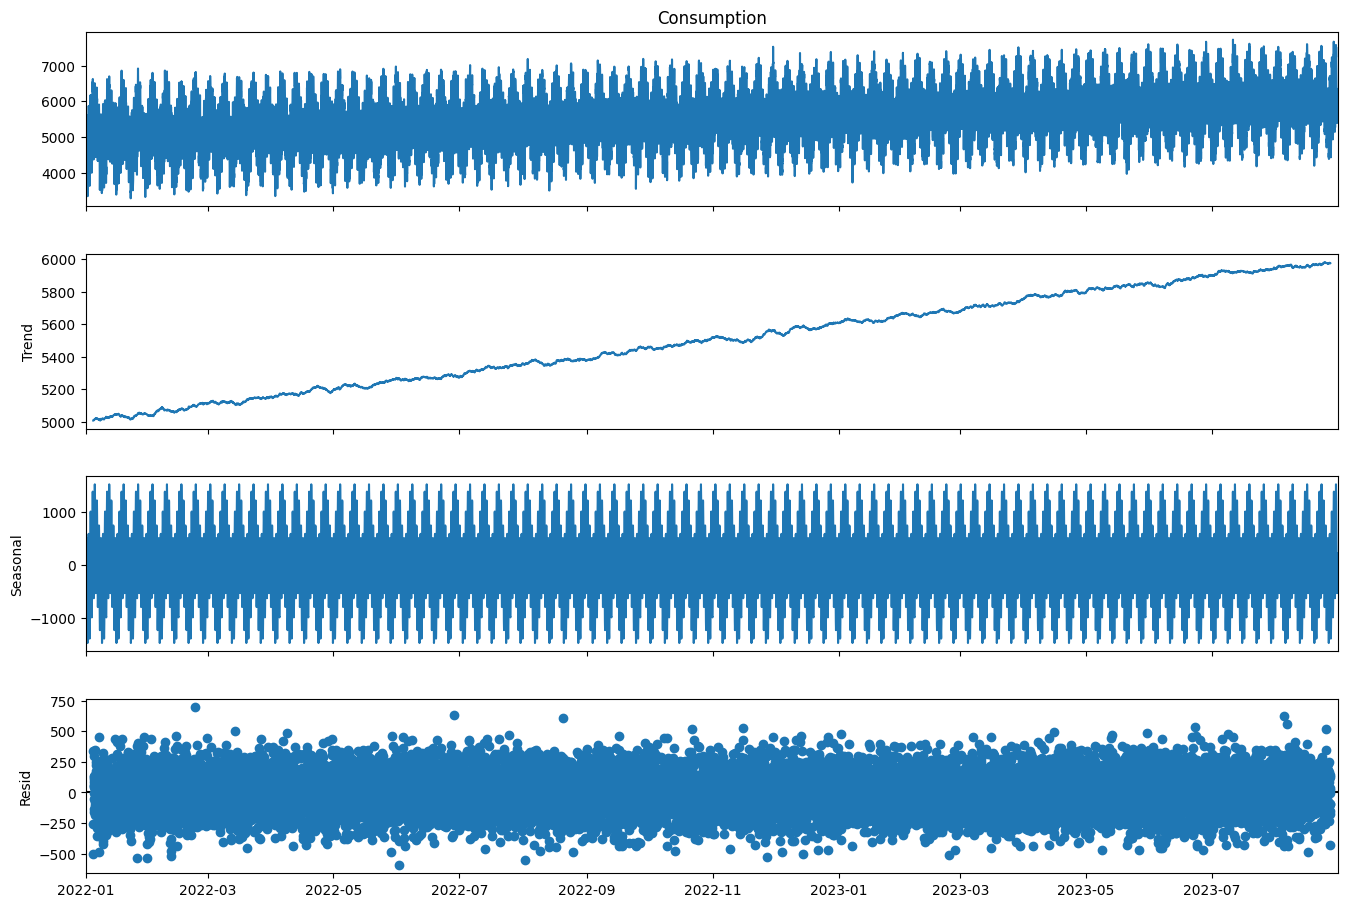

In [4]:
decomposition = seasonal_decompose(df['Consumption'], model='additive', period=24*7) 
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()

In [5]:
train_data = df.iloc[:-45*24]
test_data = df.iloc[-45*24:]

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24) 
seasonal_order_weekly = (1, 1, 1, 24*7) 


sarimax_model = SARIMAX(train_data['Consumption'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_results = sarimax_model.fit(disp=False)

sarimax_forecast_15 = sarimax_results.get_forecast(steps=15*24)
sarimax_forecast_30 = sarimax_results.get_forecast(steps=30*24)
sarimax_forecast_45 = sarimax_results.get_forecast(steps=45*24)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [6]:
prophet_df = df.reset_index().rename(columns={'DateTime': 'ds', 'Consumption': 'y'})
prophet_train_df = prophet_df.iloc[:-45*24]
prophet_test_df = prophet_df.iloc[-45*24:]

prophet_model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True
)
prophet_model.fit(prophet_train_df)

12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future_15 = prophet_model.make_future_dataframe(periods=15*24, freq='H')
future_30 = prophet_model.make_future_dataframe(periods=30*24, freq='H')
future_45 = prophet_model.make_future_dataframe(periods=45*24, freq='H')

prophet_forecast_15 = prophet_model.predict(future_15)
prophet_forecast_30 = prophet_model.predict(future_30)
prophet_forecast_45 = prophet_model.predict(future_45)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [8]:
df_reg = df.copy()
df_reg['hour'] = df_reg.index.hour
df_reg['dayofweek'] = df_reg.index.dayofweek
df_reg['lag_24'] = df_reg['Consumption'].shift(24)
df_reg['lag_168'] = df_reg['Consumption'].shift(168)

df_reg.dropna(inplace=True)

X = df_reg[['hour', 'dayofweek', 'lag_24', 'lag_168']]
y = df_reg['Consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=45*24/len(X), shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE для Random Forest: {rmse_rf}")

RMSE для Random Forest: 204.104605643313


In [12]:
def evaluate_and_plot(model_name, y_true, y_pred, df_historical, test_data_index, forecast_steps):
    """Calculates metrics and plots the forecast for a specific horizon."""
    y_true = y_true[:forecast_steps]
    y_pred = y_pred[:forecast_steps]
    test_index = test_data_index[:forecast_steps]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"Metrics for {model_name} (Forecast: {forecast_steps} hours / {forecast_steps//24} days):")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    
    plt.figure(figsize=(15, 6))
    plt.plot(df_historical.index, df_historical['Consumption'], label='Історичні дані', color='blue')
    plt.plot(test_index, y_pred, label=f'Прогноз {model_name}', color='orange', linestyle='--')
    plt.plot(test_index, y_true, label='Фактичні дані', color='red', alpha=0.6)
    plt.title(f'Прогноз {model_name} на {forecast_steps//24} днів vs. Фактичні дані')
    plt.xlabel('Дата')
    plt.ylabel('Споживання (МВт·год)')
    plt.legend()
    plt.grid(True)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Metrics for Prophet (Forecast: 360 hours / 15 days):
  RMSE: 183.19
  MAE:  151.40


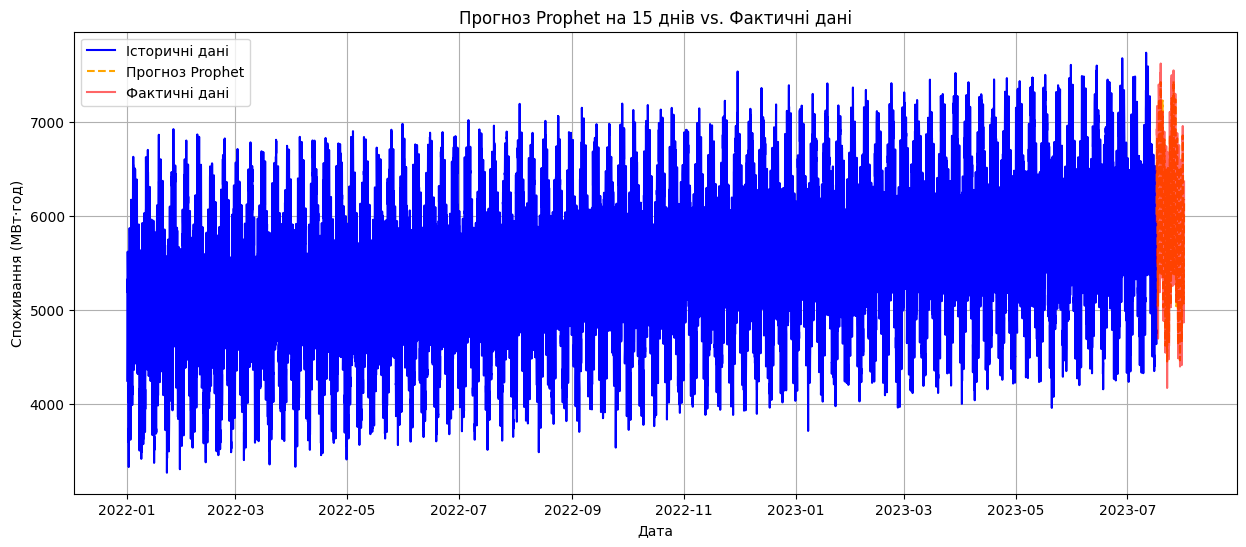

Metrics for Prophet (Forecast: 720 hours / 30 days):
  RMSE: 177.40
  MAE:  143.21


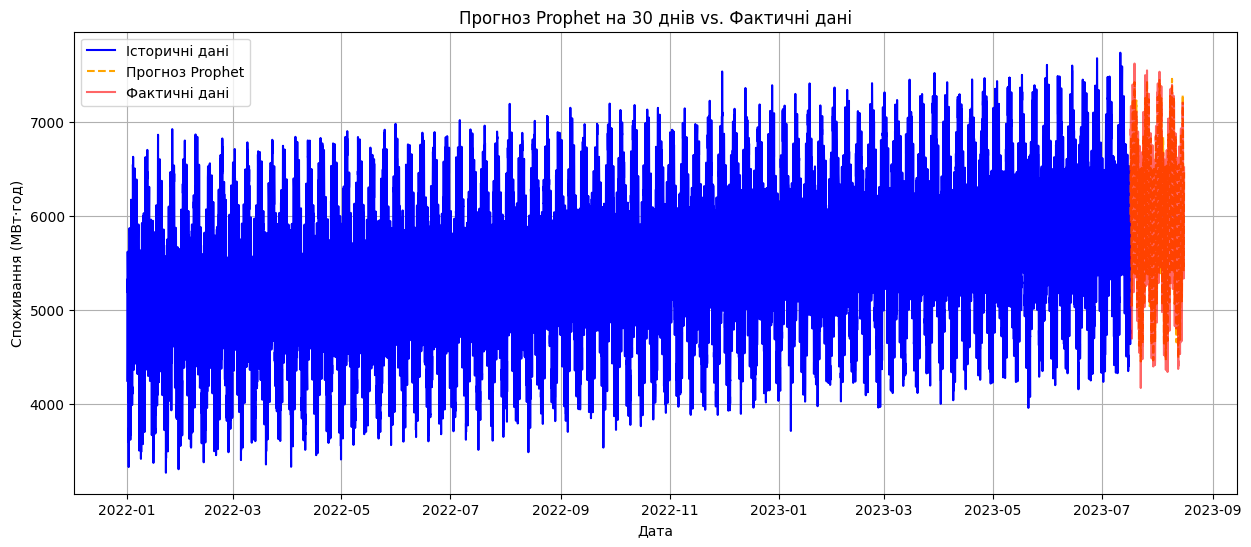

Metrics for Prophet (Forecast: 1080 hours / 45 days):
  RMSE: 175.26
  MAE:  140.52


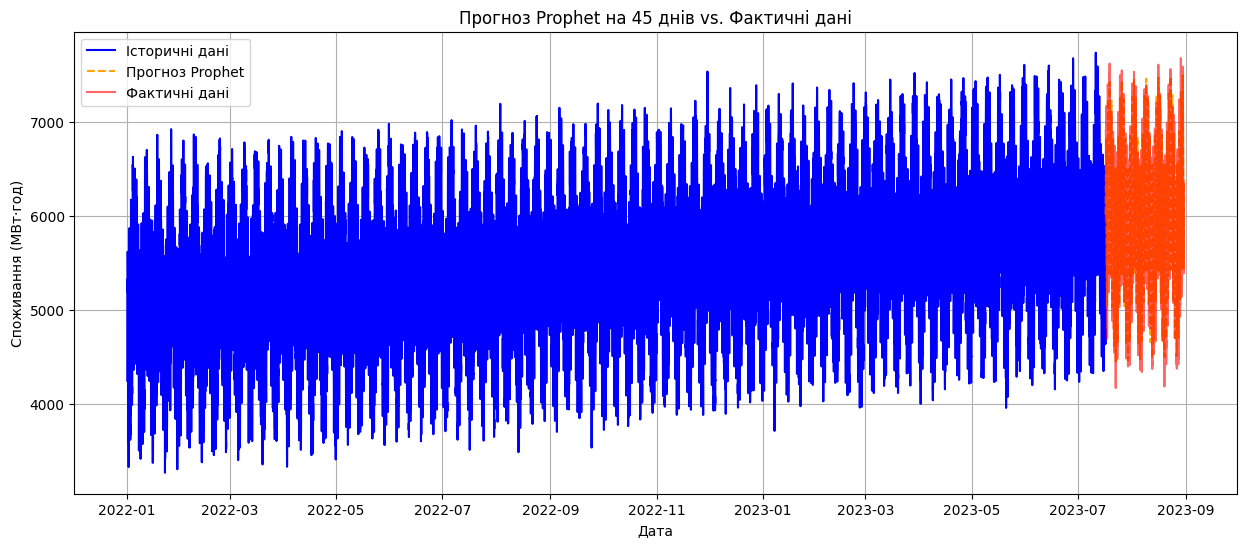

In [ ]:
future = prophet_model.make_future_dataframe(periods=45*24, freq='H')
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast['yhat'].values[-45*24:]

for days in [15, 30, 45]:
    evaluate_and_plot("Prophet", test_data['Consumption'], prophet_pred, train_data, test_data.index, days * 24)

Metrics for Random Forest (Forecast: 360 hours / 15 days):
  RMSE: 1112.40
  MAE:  913.29


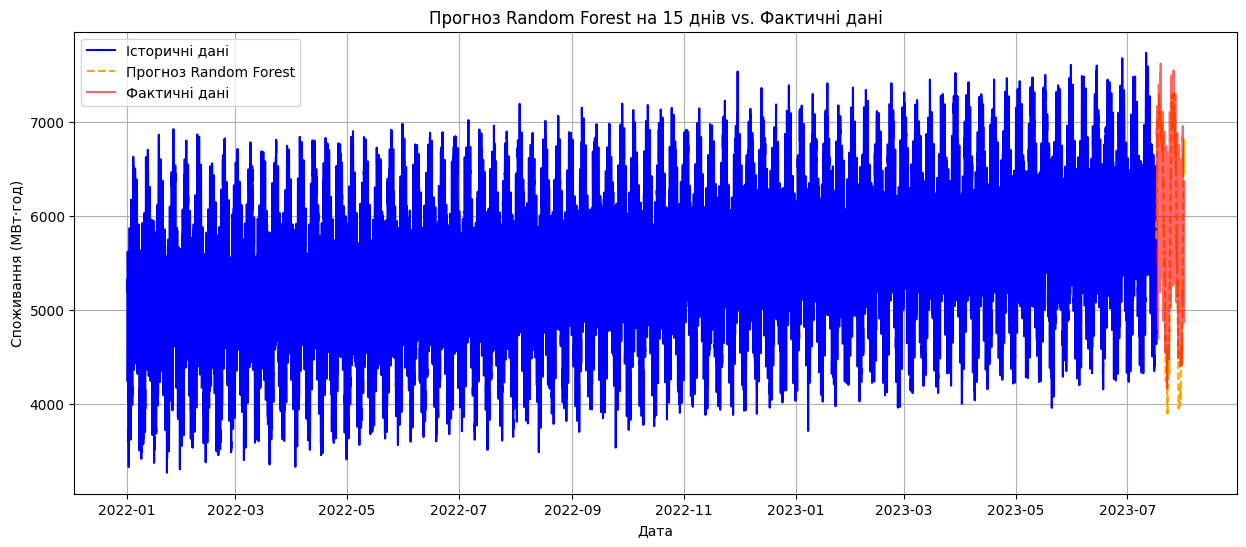

Metrics for Random Forest (Forecast: 720 hours / 30 days):
  RMSE: 1126.15
  MAE:  922.88


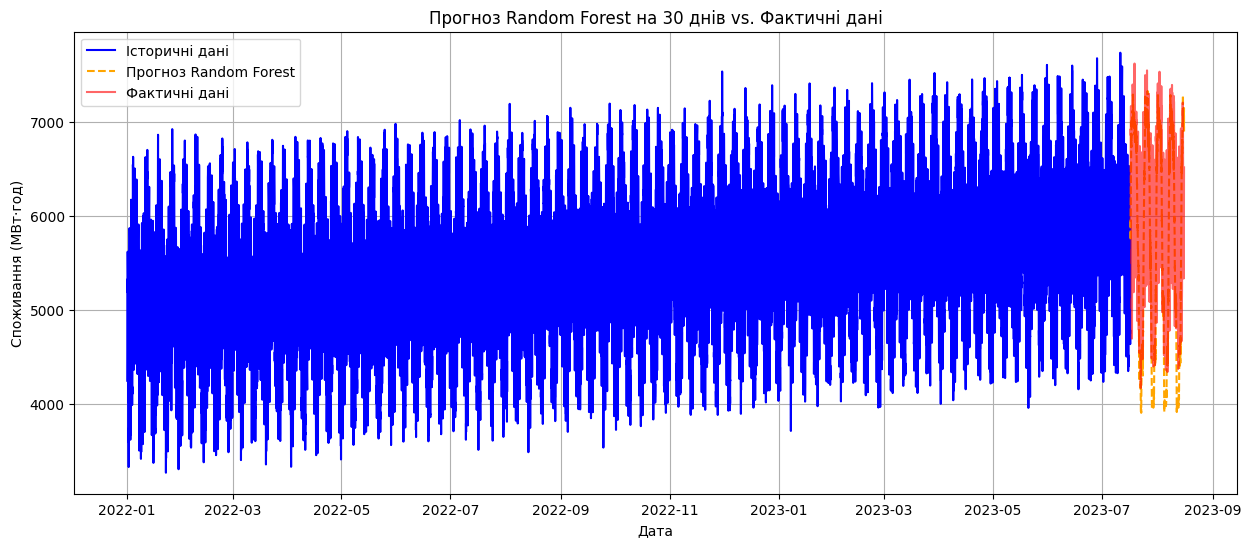

Metrics for Random Forest (Forecast: 1080 hours / 45 days):
  RMSE: 1131.75
  MAE:  928.76


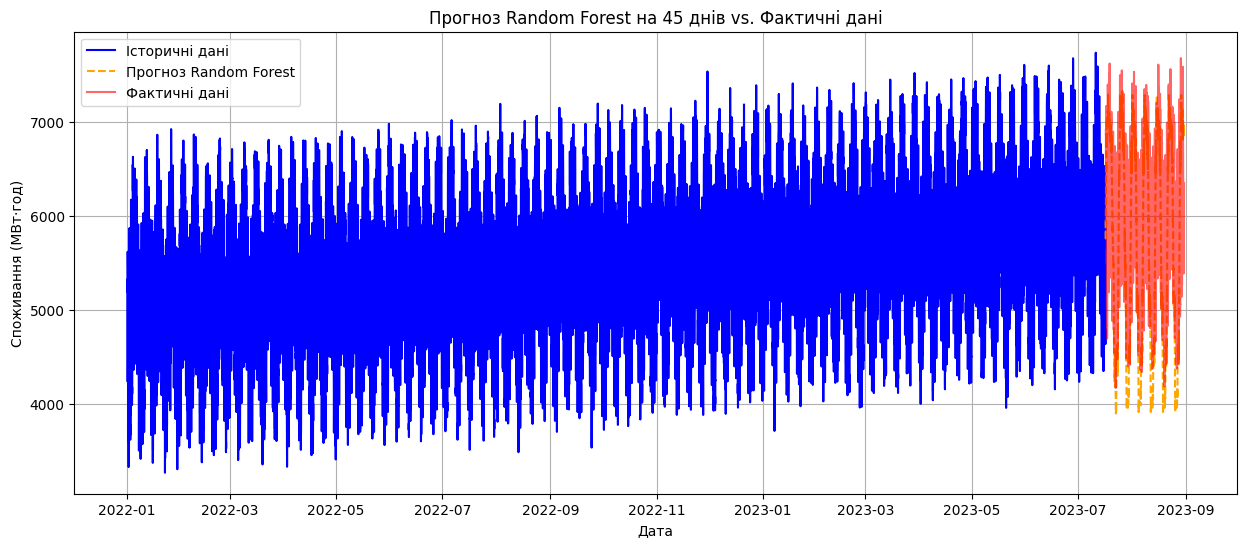

In [15]:
rf_pred_list = []
last_observation = X_train.iloc[-1].to_dict()
for i in range(45*24):
    input_data = pd.DataFrame([last_observation])
    pred = rf_model.predict(input_data)[0]
    rf_pred_list.append(pred)
    # Оновлення лагів для наступного кроку
    last_observation['lag_168'] = last_observation['lag_24']
    last_observation['lag_24'] = pred
    last_observation['hour'] = test_data.index[i].hour
    last_observation['dayofweek'] = test_data.index[i].dayofweek
rf_pred = np.array(rf_pred_list)

for days in [15, 30, 45]:
    evaluate_and_plot("Random Forest", test_data['Consumption'], rf_pred, train_data, test_data.index, days * 24)


Metrics for SARIMAX (Forecast: 360 hours / 15 days):
  RMSE: 405.18
  MAE:  340.50


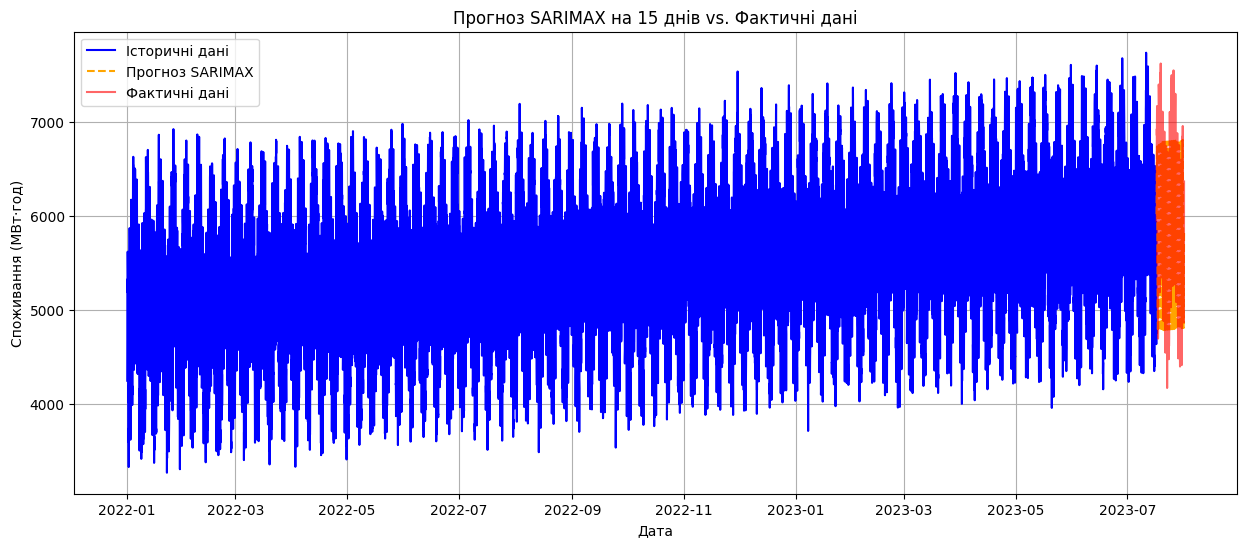

Metrics for SARIMAX (Forecast: 720 hours / 30 days):
  RMSE: 411.61
  MAE:  350.67


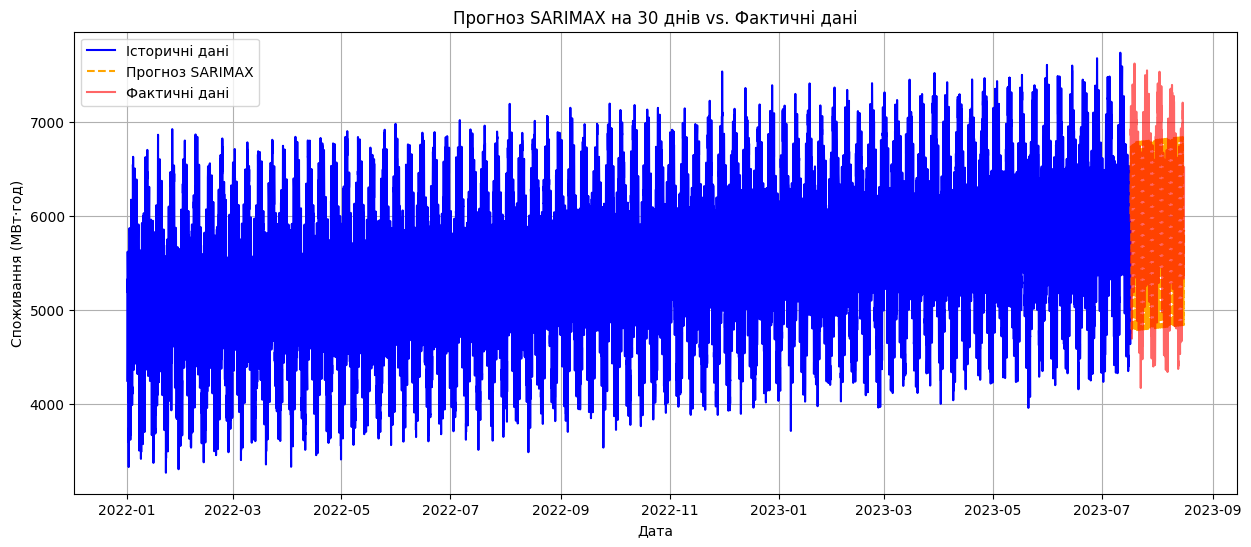

Metrics for SARIMAX (Forecast: 1080 hours / 45 days):
  RMSE: 415.60
  MAE:  355.26


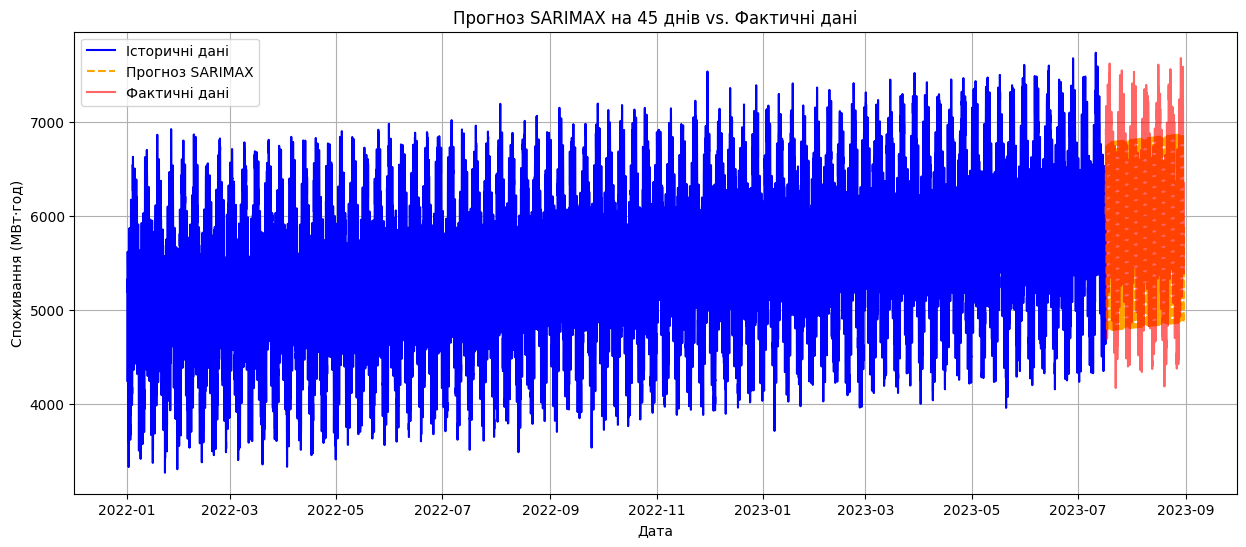

In [19]:
sarimax_forecast_full = sarimax_results.get_forecast(steps=45 * 24)
sarimax_pred = sarimax_forecast_full.predicted_mean

for days in [15, 30, 45]:
    evaluate_and_plot("SARIMAX", test_data['Consumption'], sarimax_pred, train_data, test_data.index, days * 24)